<a href="https://colab.research.google.com/github/ShivaniGawande/DLMiniProject_Fall22/blob/main/EDA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import gc
from itertools import compress
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                         
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

NULL_VALUES_THRESHOLD = 0.95

## Loading Data 

In [ ]:
#loading amex data (parquet form) from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1JKPJVwQjn72xuXjFpz_DQy6MZtbNFg_2' 
test_file_id = '1ADD4KUHP4nSz_-YBEFClD1DTpSZhmMM-'
train_labels_file_id = '1kEh1YWz1xyHifimo_3y5vzyNEV_Lk0ZA'

download = drive.CreateFile({'id': train_file_id})
# Download the training data to a local disc
download.GetContentFile('train-data.parquet')
train_data  = pd.read_parquet("train-data.parquet")
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


## Preprocessing the data

In [ ]:
# Checking the train size
train_data.shape

(5531451, 191)

In [ ]:
# Checking the time range of payments, since the data is sequential.
print(f'Train dates range is from {train_data["S_2"].min()} to {train_data["S_2"].max()}.')

Train dates range is from 2017-03-01 to 2018-03-31.


In [ ]:
# Chnaging the dtype of the categorical features in the data 
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train_data[categorical_features] = train_data[categorical_features].astype("category")
train_data[categorical_features].dtypes

B_30     category
B_38     category
D_63     category
D_64     category
D_66     category
D_68     category
D_114    category
D_116    category
D_117    category
D_120    category
D_126    category
dtype: object

In [ ]:
train_data.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

## EDA

In [ ]:
# Checking the frequency of different feature types/ variables
f_Del = [c for c in train_data.columns if c.startswith('D_')]
f_Spd = [c for c in train_data.columns if c.startswith('S_')]
f_Pay = [c for c in train_data.columns if c.startswith('P_')]
f_Bal = [c for c in train_data.columns if c.startswith('B_')]
f_Risk = [c for c in train_data.columns if c.startswith('R_')]
print(f'Total number of Delinquency variables: {len(f_Del)}')
print(f'Total number of Spend variables: {len(f_Spd)}')
print(f'Total number of Payment variables: {len(f_Pay)}')
print(f'Total number of Balance variables: {len(f_Bal)}')
print(f'Total number of Risk variables: {len(f_Risk)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


In [ ]:
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(f_Del), len(f_Spd),len(f_Pay), len(f_Bal),len(f_Risk)]

In [ ]:
# Plotting feature distribution
fig = go.Figure()
fig.add_trace(go.Pie(values = values,labels = labels,hoverinfo ='label+percent', hole = 0.6, 
))
fig.update_traces(textfont_size = 13,showlegend = False, hoverinfo ='label+percent',textinfo ='label', 
                  title = dict(text = 'Feature Distribution'))  
fig.show()

In [ ]:
# Checking the missing values in training set
missing_values = train_data.isna().sum()
print("Total missing values" , sum(missing_values))

Total missing values 160858968


In [ ]:
#Custom Color Palette 
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

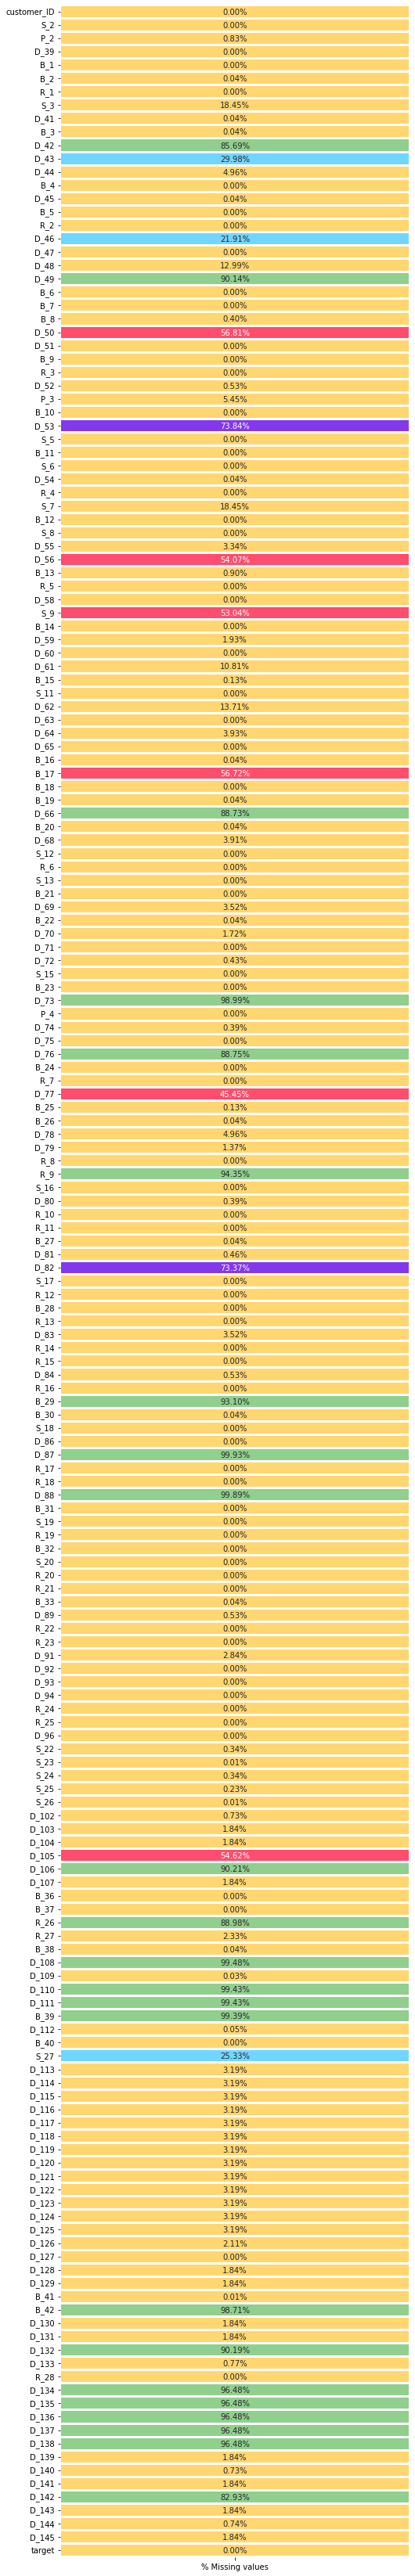

In [ ]:
# Plotting the percentage of missing values in each feature
missing = pd.DataFrame(columns = ['% Missing values'],data = train_data.isnull().sum()/len(train_data))
fig = plt.figure(figsize = (20, 60),facecolor='white')
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.5, hspace = 0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar = False,annot = True,fmt =".2%", linewidths = 2,cmap = custom_colors,vmax = 1, ax = ax0)
plt.show()

In [ ]:
# Visualizing the time period 
stat_plot = train_data.reset_index().groupby('S_2')['customer_ID'].nunique().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x = stat_plot['S_2'], y = stat_plot['customer_ID']))
fig.update_layout(title="Customer Statements", width = 800, height = 600,xaxis_title ='Statement Date',
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)') 
fig['data'][0]['line']['color']="#ff9770"
fig.show()

In [ ]:
import gc
gc.collect()

438

In [ ]:
target_class = pd.DataFrame({'count': train_data['target'].value_counts(),
                             'percentage': train_data['target'].value_counts() / train_data.shape[0] * 100
})

target_class

,count,percentage
0,4153582,75.090279
1,1377869,24.909721


In [ ]:
# Plotting the traget distribution, we gather that there exist a class imbalance
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,
                  title = dict(text = 'Target Distribution'))  
fig.show()

In [ ]:
default_class = train_data[train_data['target']==1]
default_class.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,0.400025,0.000278,0.954861,0.023890,0.003140,NaN,0.008421,1.175081,...,NaN,NaN,1.002518,0.001170,0.870115,0.141214,1.003923,0.008945,0.736632,1
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,0.405788,0.000269,0.944042,0.025613,0.008950,NaN,0.003707,1.177973,...,NaN,NaN,1.005944,0.003116,0.864712,0.145885,1.004833,0.002125,0.733311,1
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,0.403615,0.032850,0.940261,0.026016,0.009074,NaN,0.008000,1.175785,...,NaN,NaN,1.006883,0.004455,0.871729,0.144555,1.000521,0.000765,0.729252,1
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,0.391495,0.034461,0.936253,0.029538,0.005778,NaN,0.002849,1.174703,...,NaN,NaN,1.000132,0.002175,0.869414,0.151890,1.001034,0.008195,0.727660,1
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,0.392356,0.037955,0.915764,0.028671,0.008595,NaN,0.002428,1.177958,...,NaN,NaN,1.001192,0.004609,0.869089,0.152654,1.007116,0.001493,0.727649,1


In [ ]:
paid_class = train_data[train_data['target']==0]
paid_class.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [ ]:
del_cols = [c for c in train_data.columns if (c.startswith(('D','t'))) & (c not in categorical_features)]
df_del = train_data[del_cols]
spd_cols = [c for c in train_data.columns if (c.startswith(('S','t'))) & (c not in categorical_features)]
df_spd = train_data[spd_cols]
pay_cols = [c for c in train_data.columns if (c.startswith(('P','t'))) & (c not in categorical_features)]
df_pay = train_data[pay_cols]
bal_cols = [c for c in train_data.columns if (c.startswith(('B','t'))) & (c not in categorical_features)]
df_bal = train_data[bal_cols]
ris_cols = [c for c in train_data.columns if (c.startswith(('R','t'))) & (c not in categorical_features)]
df_ris = train_data[ris_cols]

### Feature correlation in default class

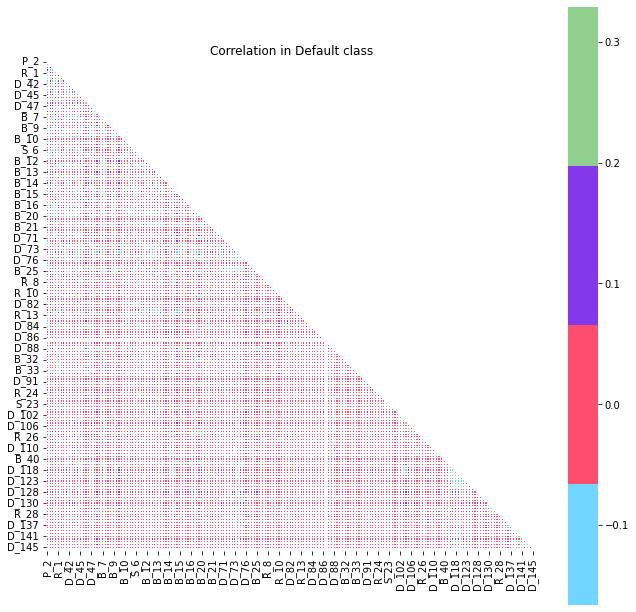

In [ ]:
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

plt.figure(figsize =(11,11))
corr = default_class.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation in Default class')
plt.show()

### Feature correlation in paid class

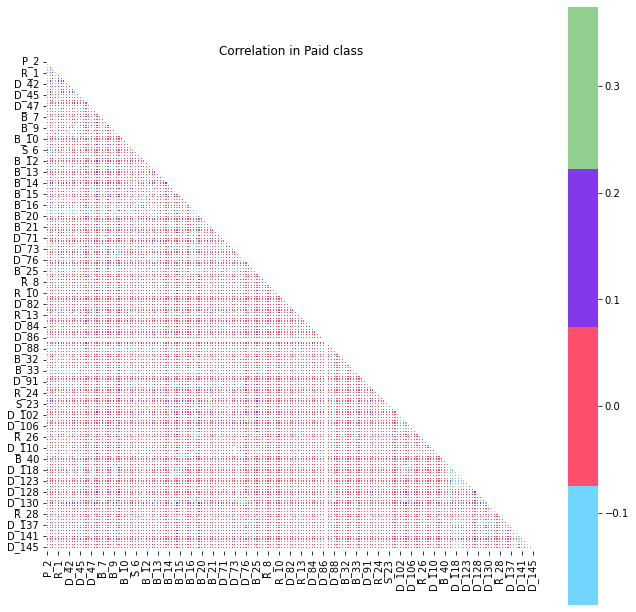

In [ ]:
plt.figure(figsize =(11,11))
corr = paid_class.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation in Paid class')
plt.show()

### Correlation between different variable types with themselves

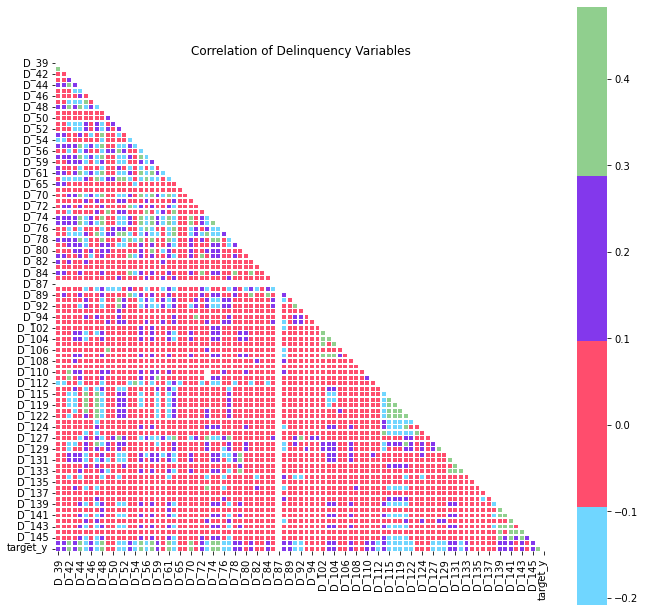

In [ ]:
plt.figure(figsize =(11,11))
corr = df_del.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Delinquency Variables')
plt.show()

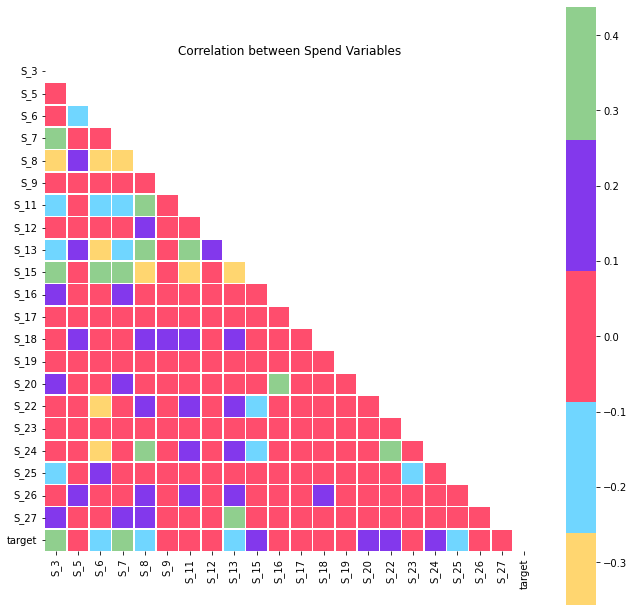

In [ ]:
plt.figure(figsize =(11,11))
corr = df_spd.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Spend Variables')
plt.show()

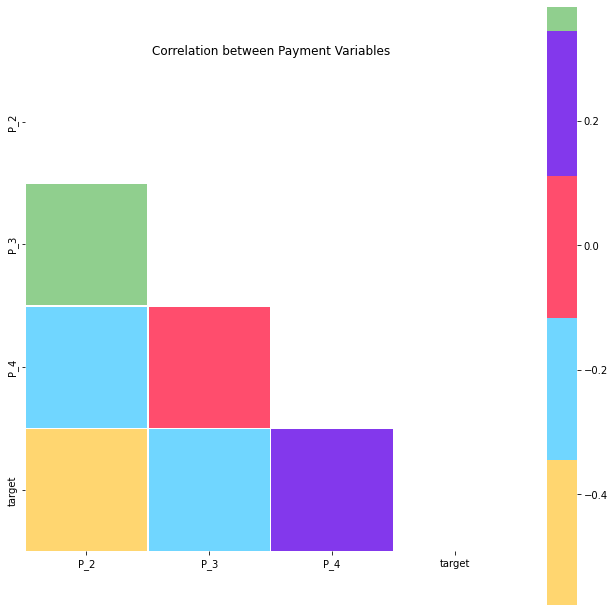

In [ ]:
plt.figure(figsize =(11,11))
corr = df_pay.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Payment Variables')
plt.show()

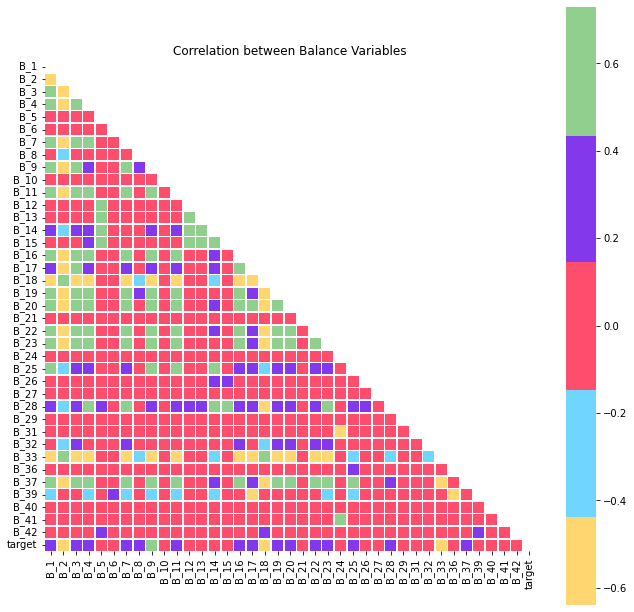

In [ ]:
plt.figure(figsize =(11,11))
corr = df_bal.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Balance Variables')
plt.show()

### Dependency of different variable types on payment variables

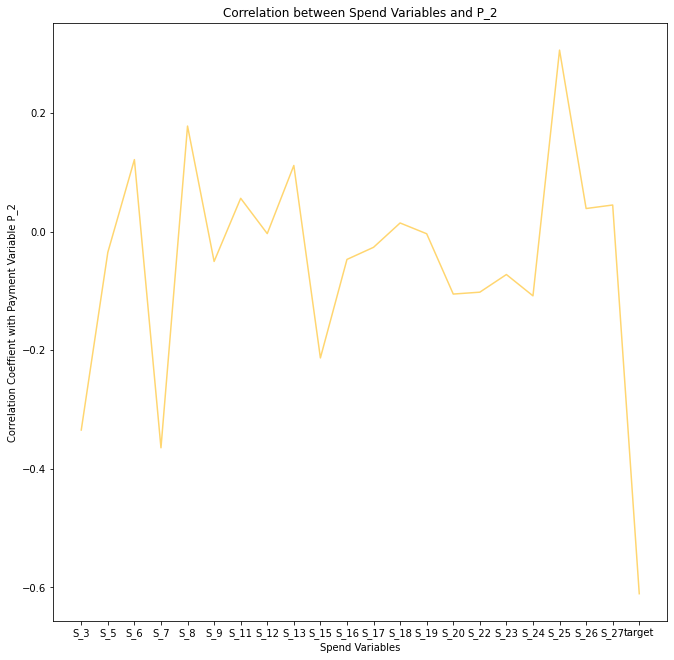

In [ ]:
plt.figure(figsize =(11,11))
corr = df_spd.corrwith(df_pay.P_2)
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.plot(corr)
plt.xlabel("Spend Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Spend Variables and P_2')
plt.show()

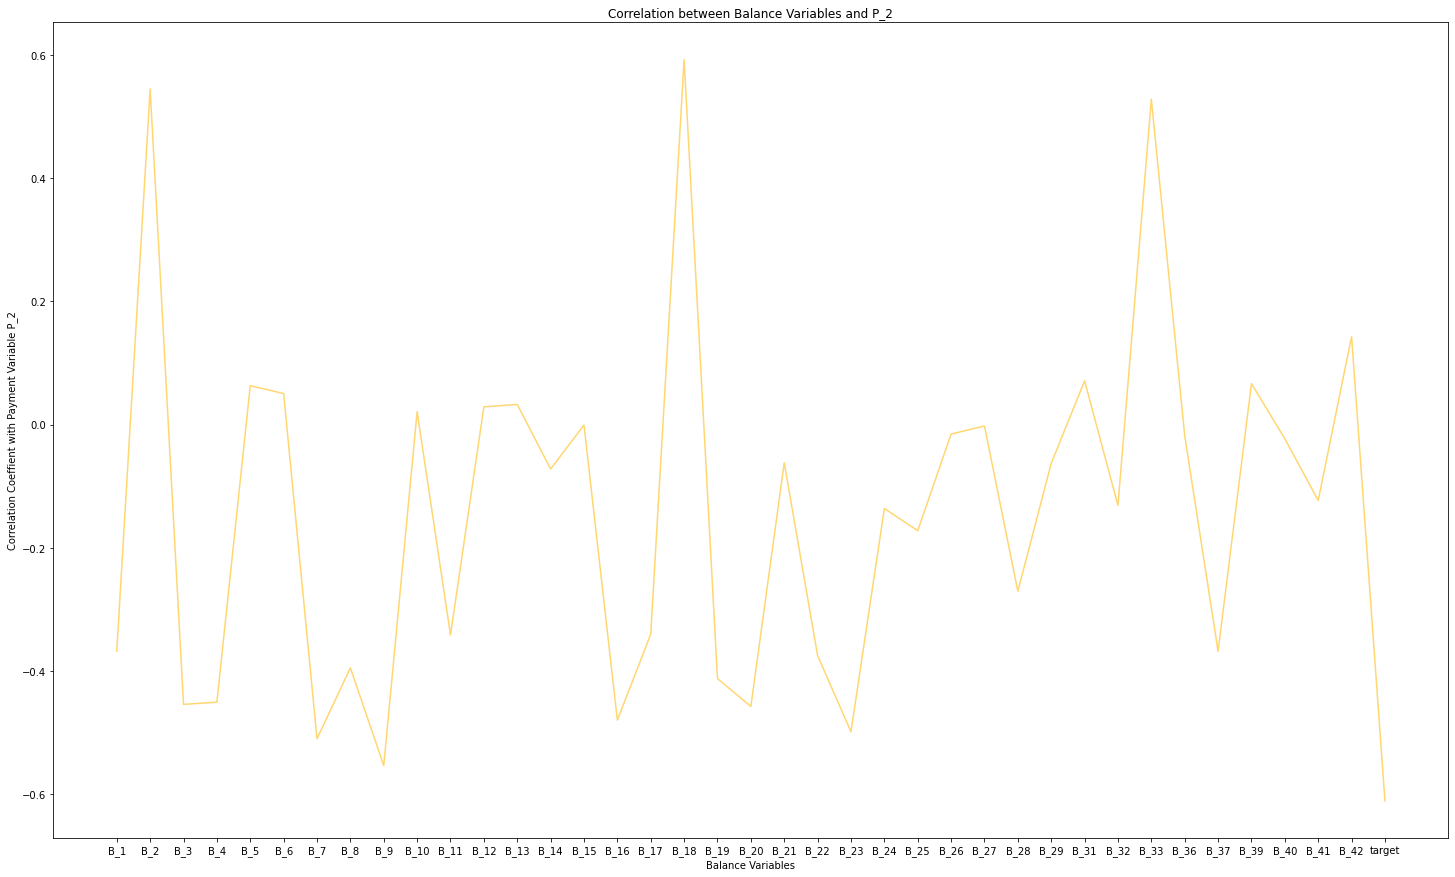

In [ ]:
plt.figure(figsize =(25,15))
corr = df_bal.corrwith(df_pay.P_2)
plt.plot(corr)
plt.xlabel("Balance Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Balance Variables and P_2')
plt.show()

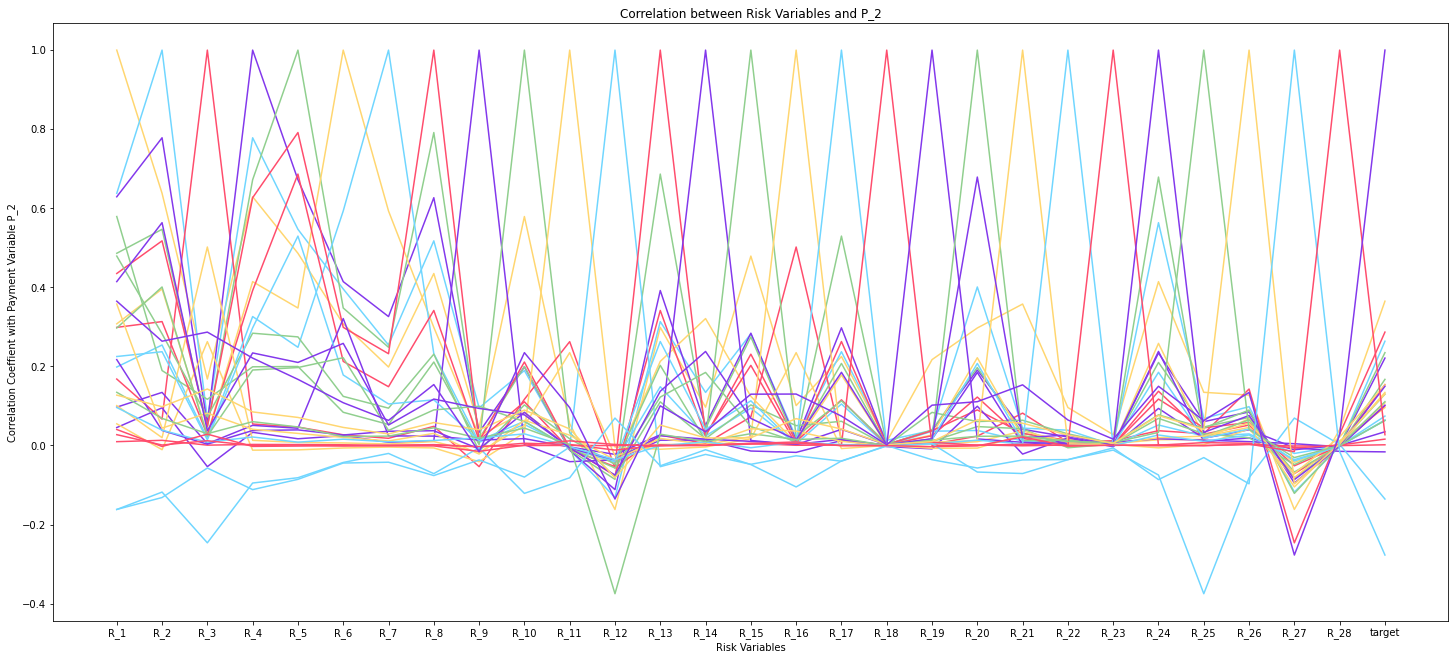

In [ ]:
plt.figure(figsize =(25,11))
corr = df_ris.corrwith(df_pay.P_2)
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.plot(corr)
plt.xlabel("Risk Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Risk Variables and P_2')
plt.show()

## Preprocessing data for training model

In [ ]:
#remove colmuns that have more then THRESHOLD precent of missing values
print(train_data.shape)
train_data = train_data.dropna(axis=1, thresh=int(NULL_VALUES_THRESHOLD*train_data.shape[0]))
print(train_data.shape)

(5531451, 191)
(5531451, 151)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 151 entries, customer_ID to target
dtypes: category(10), float32(137), int64(2), object(2)
memory usage: 3.1+ GB


In [ ]:
# Dropping the rows with na 
train_data = train_data.dropna()
print(train_data.shape)

(4825496, 151)


In [ ]:
cat_cols = ['customer_ID', 'S_2', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

In [ ]:
# tranforming categorical features to fit catboost input requiremnets
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
for cat_feat in cat_cols:
    train_data[cat_feat] = lab_enc.fit_transform(train_data[cat_feat])

In [ ]:
# define dataset
X = train_data.drop('target', axis=1)
y = train_data['target']

In [ ]:
from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split
X_train, X_valid , y_train , y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42) # 80-20 split

In [ ]:
X_train.dtypes != 'float32'

customer_ID     True
S_2             True
P_2            False
D_39           False
B_1            False
               ...  
D_140          False
D_141          False
D_143          False
D_144          False
D_145          False
Length: 150, dtype: bool

In [ ]:
X_train.isna().any()

customer_ID    False
S_2            False
P_2            False
D_39           False
B_1            False
               ...  
D_140          False
D_141          False
D_143          False
D_144          False
D_145          False
Length: 150, dtype: bool

## Training

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
# defining model and training
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations = 3000, random_state = 42, nan_mode ='Min',task_type ="GPU")
clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], cat_features=cat_cols,  verbose = 100)

Learning rate set to 0.022823
0:	learn: 0.6344583	test: 0.6302826	best: 0.6302826 (0)	total: 110ms	remaining: 5m 28s
100:	learn: 0.0406782	test: 0.0010252	best: 0.0010252 (100)	total: 8.63s	remaining: 4m 7s
200:	learn: 0.0387606	test: 0.0009594	best: 0.0009594 (200)	total: 16.9s	remaining: 3m 55s
300:	learn: 0.0381119	test: 0.0009416	best: 0.0009416 (300)	total: 25.6s	remaining: 3m 49s
400:	learn: 0.0377190	test: 0.0009305	best: 0.0009305 (400)	total: 34.9s	remaining: 3m 46s
500:	learn: 0.0374359	test: 0.0009234	best: 0.0009234 (500)	total: 44.3s	remaining: 3m 40s
600:	learn: 0.0372013	test: 0.0009194	best: 0.0009194 (599)	total: 53.7s	remaining: 3m 34s
700:	learn: 0.0370224	test: 0.0009163	best: 0.0009163 (697)	total: 1m 3s	remaining: 3m 28s
800:	learn: 0.0368707	test: 0.0009137	best: 0.0009136 (796)	total: 1m 13s	remaining: 3m 20s
900:	learn: 0.0367661	test: 0.0009118	best: 0.0009118 (900)	total: 1m 22s	remaining: 3m 12s
1000:	learn: 0.0366426	test: 0.0009095	best: 0.0009095 (1000)	t

## Evaluation

Text(0.5, 1.0, 'Feature Importance')

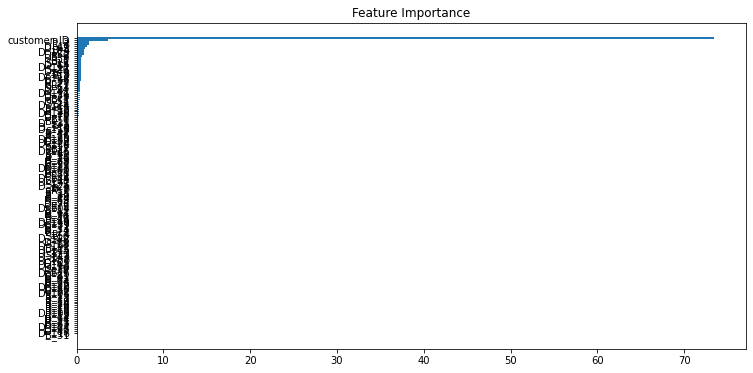

In [ ]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
# perdection on the test set
preds = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# print accuracy
print("Accuracy: ", accuracy_score(y_test, preds))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_test, preds))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_test, preds))


Accuracy:  0.9996135115532069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    733049
           1       1.00      1.00      1.00    232051

    accuracy                           1.00    965100
   macro avg       1.00      1.00      1.00    965100
weighted avg       1.00      1.00      1.00    965100

[[732876    173]
 [   200 231851]]
